# TM10007 Assignment template

In [12]:
# Run this to use from colab environment
#!pip install -q --upgrade git+https://github.com/karinvangarderen/tm10007_project.git

## Data loading and cleaning

Below are functions to load the dataset of your choice. After that, it is all up to you to create and evaluate a classification method. Beware, there may be missing values in these datasets. Good luck!

In [1]:
# Import functions
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.svm import SVC
from brats.load_data import load_data
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.impute import KNNImputer
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Import data
data = load_data()
print(f'The number of samples: {len(data.index)}')
print(f'The number of columns: {len(data.columns)}')

The number of samples: 167
The number of columns: 725


In [3]:
remove_features = data.T[data.isna().sum(axis=0) < 130]
removed_features = remove_features.T
print(f'The number of samples: {len(removed_features)}')
print(f'The number of columns: {len(removed_features.columns)}')

The number of samples: 167
The number of columns: 705


In [4]:
#impute Nans

label = removed_features['label'].to_numpy() #extract labels
features = removed_features.drop('label', axis=1) #dropped laatste kolom (labels)
replace_div = features.replace(r'#DIV/0!', 'nan', regex=True) #DIV's worden vervangen door nan 
replace_inf = replace_div.replace(np.inf, np.nan, regex=True) #inf wordt vervangen door nan

feature_names = list(replace_inf.columns) #extract feature names
imputer = KNNImputer(n_neighbors=10) #definieert functie K-nearest neighbor imputer
clean_data = imputer.fit_transform(replace_inf) #alle nan's worden vervangen op basis van k-NN imputer

In [5]:
#convert labels to true and false
labels = label=='GBM'

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(clean_data, labels, test_size=0.2, stratify=labels)

In [7]:
from scipy import stats
k2, p = stats.normaltest(X_train)
alpha = 0.05
count_normal = 0 
for value in p:
    if value > alpha:  # null hypothesis: x comes from a normal distribution
        count_normal += 1
print(count_normal)

67


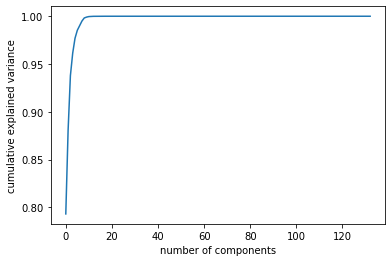

<Figure size 432x288 with 0 Axes>

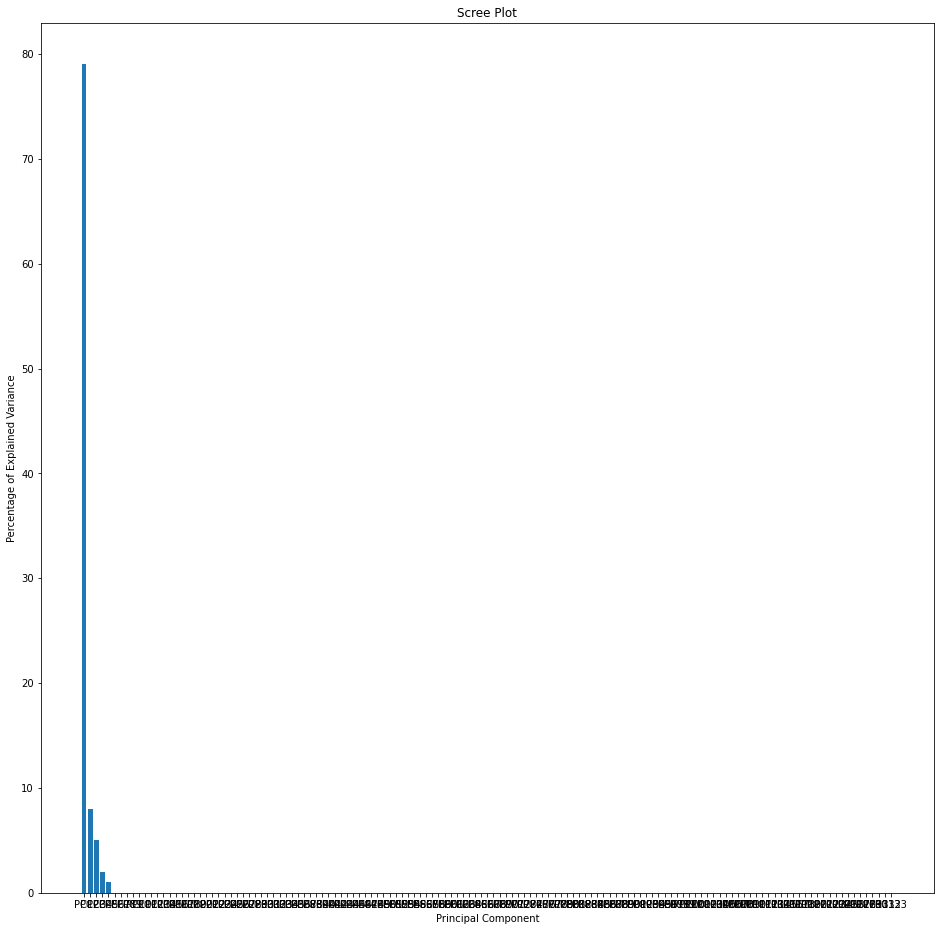

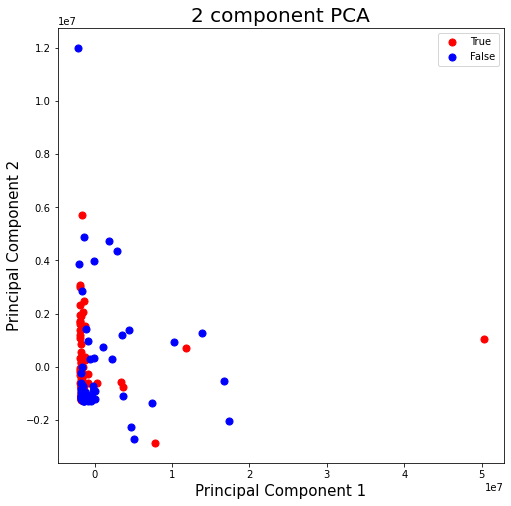

In [8]:
# check # components for PCA
#Standard Scaling
scaler = StandardScaler().fit(X_train)
data_train = scaler.transform(X_train)
label_df = pd.DataFrame(data=y_train, columns=['target'])

#PCA
pca = PCA().fit(X_train)
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
pca_data = pca.transform(X_train)

per_var = np.round(pca.explained_variance_ratio_* 100, decimals=1)
per_var_array = per_var.squeeze().astype(np.int)
pca_labels = ['PC' + str(x) for x in range(1, len(per_var_array)+1)]
plt.figure()
fig = plt.figure(figsize = (16,16))
plt.bar(x=range(1,len(per_var_array)+1), height=per_var_array, tick_label=pca_labels)
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Principal Component')
plt.title('Scree Plot')
plt.show()

pca_data = pd.DataFrame(data= pca_data, columns= pca_labels)
finalDf = pd.concat([pca_data, label_df], axis= 1)
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)
targets = [True, False]
colors = ['r', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf['target'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'PC1'], finalDf.loc[indicesToKeep, 'PC2'], c = color, s = 50)
    ax.legend(targets)
    ax.grid()

In [9]:
pipeline_linear = Pipeline([('scalar1',StandardScaler()),
                     ('pca1',PCA(n_components=10)),
                     ('lr_classifier',LinearDiscriminantAnalysis())])

In [10]:
pipeline_quadratic = Pipeline([('scalar2',StandardScaler()),
                     ('pca4',PCA(n_components=10)),
                     ('qda_classifier',QuadraticDiscriminantAnalysis())])

In [11]:
pipelines = [pipeline_linear, pipeline_quadratic]
best_accuracy=0.0
best_classifier=0
best_pipeline=""

In [12]:
# Dictionary of pipelines and classifier types for ease of reference
pipe_dict1 = {0: 'Linear Discriminant Analysis', 1: 'Quadratic Discriminant Analysis'}

rskf = StratifiedKFold(n_splits=5) 

for train_index, validate_index in rskf.split(X_train, y_train):
	data_train, data_validate = X_train[train_index], X_train[validate_index]
	label_train, label_validate = y_train[train_index], y_train[validate_index]
	for pipe in pipelines:
		pipe.fit(data_train, label_train)

In [13]:
#Determine accuracy for each classifier
for i,model in enumerate(pipelines):
    print("{} Test Accuracy: {}".format(pipe_dict1[i],model.score(data_validate,label_validate)))

Linear Discriminant Analysis Test Accuracy: 0.8076923076923077
Quadratic Discriminant Analysis Test Accuracy: 0.9230769230769231


In [14]:
pipeline_rf = Pipeline([('scalar3',StandardScaler()),
                     ('pca3',PCA(n_components=10)),
                     ('rf_classifier',RandomForestClassifier())])

In [15]:
pipeline_svm = Pipeline([('scalar4',StandardScaler()),
                     ('pca4',PCA(n_components=10)),
                     ('svm_classifier',SVC())])

In [16]:
pipelines = [pipeline_rf, pipeline_svm]
best_accuracy=0.0
best_classifier=0
best_pipeline=""

In [17]:
pipe_dict2 = {0: 'Random Forest', 1: 'SVM'}
rskf = StratifiedKFold(n_splits=5) 

for train_index, validate_index in rskf.split(X_train, y_train):
	data_train, data_validate = X_train[train_index], X_train[validate_index]
	label_train, label_validate = y_train[train_index], y_train[validate_index]
	for pipe in pipelines:
		pipe.fit(data_train, label_train)

In [18]:
#Determine accuracy for each classifier
for i,model in enumerate(pipelines):
    print("{} Test Accuracy: {}".format(pipe_dict2[i],model.score(data_validate,label_validate)))

Random Forest Test Accuracy: 0.8461538461538461
SVM Test Accuracy: 0.8461538461538461


In [19]:
#Determine best classifier
for i,model in enumerate(pipelines):
    if model.score(data_validate,label_validate)>best_accuracy:
        best_accuracy=model.score(data_validate,label_validate)
        best_pipeline=model
        best_classifier=i
print('Classifier with best accuracy:{}'.format(pipe_dict2[best_classifier]))

Classifier with best accuracy:Random Forest


In [7]:
rskf = StratifiedKFold(n_splits=5) #ik heb random state verwijderd, daardoor worden steeds dezelfde r splits gemaakt
auc= []
accuracy= []
F1= []
precision = []
recall= []
for train_index, validate_index in rskf.split(X_train, y_train):
    data_train, data_validate = X_train[train_index], X_train[validate_index]
    label_train, label_validate = y_train[train_index], y_train[validate_index]
    # Create a pipeline
    pipe = Pipeline([('scalar',StandardScaler()), ('pca',PCA(n_components=0.95)), ('classifier',RandomForestClassifier())])
    # Create dictionary with candidate learning algorithms and their hyperparameters
    grid_param = [{"classifier": [RandomForestClassifier()],
                   "classifier__n_estimators": [10, 100, 1000],
                   "classifier__max_depth":[5,8,15,25,30,None],
                   "classifier__min_samples_leaf":[2,5,10,15,100],
                   "classifier__max_leaf_nodes": [2, 5,10]}]
    # create a gridsearch of the pipeline, the fit the best model
    skf = StratifiedKFold(n_splits=7)
    gridsearch = GridSearchCV(pipe, grid_param, cv=skf, verbose=0,n_jobs=-1) # Fit grid search
    best_model = gridsearch.fit(data_train,label_train)

    # # get roc/auc info
    # y_score = best_model.predict_proba(data_validate)[:,1]
    # # # fpr = dict()
    # # # tpr = dict()
    # # # fpr, tpr, _ = roc_curve(label_validate, y_score)
    # # # roc_auc = dict()
    # # # roc_auc = auc(fpr, tpr)

    # y_pred=best_model.predict(data_validate)
    # auc.append(metrics.roc_auc_score(label_validate, y_score))
    # accuracy.append(metrics.accuracy_score(label_validate, y_pred))
    # F1.append(metrics.f1_score(label_validate,y_pred))
    # precision.append(metrics.precision_score(label_validate,y_pred))
    # recall.append(metrics.recall_score(label_validate, y_pred))

    y_score = best_model.predict_proba(X_test)[:,1]
    y_pred=best_model.predict(X_test)
    auc.append(metrics.roc_auc_score(y_test, y_score))
    accuracy.append(metrics.accuracy_score(y_test, y_pred))
    F1.append(metrics.f1_score(y_test,y_pred))
    precision.append(metrics.precision_score(y_test,y_pred))
    recall.append(metrics.recall_score(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    plot_CM(cm,'CM')


    # make the plot
    # plt.figure(figsize=(10,10))
    # plt.plot([0, 1], [0, 1], 'k--')
    # plt.xlim([-0.05, 1.0])
    # plt.ylim([0.0, 1.05])
    # plt.xlabel('False Positive Rate')
    # plt.ylabel('True Positive Rate')
    # plt.grid(True)
    # plt.plot(fpr, tpr, label='AUC = {0}'.format(roc_auc))        
    # plt.legend(loc="lower right", shadow=True, fancybox =True) 
    # plt.show()


In [8]:
from statistics import mean
print(auc)
print(accuracy)
print(F1)
print(precision)
print(recall)

[0.8461538461538463, 0.868131868131868, 0.9047619047619048, 0.8534798534798534, 0.8791208791208791]
[0.7058823529411765, 0.8235294117647058, 0.8235294117647058, 0.7941176470588235, 0.7941176470588235]
[0.7916666666666667, 0.8695652173913043, 0.8695652173913043, 0.8372093023255814, 0.8510638297872339]
[0.7037037037037037, 0.8, 0.8, 0.8181818181818182, 0.7692307692307693]
[0.9047619047619048, 0.9523809523809523, 0.9523809523809523, 0.8571428571428571, 0.9523809523809523]
